In [17]:
pip install dynamask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import argparse
import os
import pickle as pkl
from dynamask.fit.TSX.utils import load_data
import torch
import torch.utils.data as utils
from torch.utils.data import DataLoader
from dynamask.attribution.perturbation import FadeMovingAverage
from  dynamask.attribution.perturbation import GaussianBlur
from torch.nn.functional import mse_loss
from dynamask.attribution.mask import Mask
from dynamask.models.models import StateClassifier
#from dynamask.utils.losses import log_loss_target
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import Normalizer


In [3]:
Xst=pd.read_csv("/content/HDVt.csv")

In [4]:
Xtr=pd.read_csv("/content/HDV.csv")


In [5]:
Xst .reset_index(drop = True, inplace = True)
Xst.set_index('Date', inplace = True)

Xtr.reset_index(drop = True, inplace = True)
Xtr.set_index('Date', inplace = True)

In [6]:
Xtr

,Unnamed: 0,Adj Close,SMA,EMA,ROC,RSI,Y_train_data,Predicted Diff
Date,,,,,,,,
2011-06-07,0,34.314640,-0.050822,-0.200726,-2.619862,-18.432565,0.033108,0.059697
2011-06-08,1,34.347748,-0.058604,-0.193722,-1.649829,-17.520081,0.099323,0.074667
2011-06-09,2,34.447071,-0.080457,-0.163111,-1.838542,-14.737484,-0.384064,-0.280605
2011-06-10,3,34.063007,-0.154621,-0.194721,-1.045926,-19.580941,0.145683,0.150734
2011-06-13,4,34.208691,-0.157436,-0.178088,0.834016,-15.708289,0.251637,0.256792
...,...,...,...,...,...,...,...,...
2017-12-22,1649,74.751663,0.099921,0.308780,-0.369509,7.377579,-0.016586,-0.062825
2017-12-26,1650,74.735077,0.072310,0.281168,-0.513949,7.050108,0.058060,0.008061
2017-12-27,1651,74.793137,0.125708,0.257864,-0.636538,7.443619,0.107803,0.026433


In [7]:
X_train=pd.DataFrame(Xtr.drop(['Unnamed: 0','Y_train_data','Predicted Diff'],axis=1))
X_train

,Adj Close,SMA,EMA,ROC,RSI
Date,,,,,
2011-06-07,34.314640,-0.050822,-0.200726,-2.619862,-18.432565
2011-06-08,34.347748,-0.058604,-0.193722,-1.649829,-17.520081
2011-06-09,34.447071,-0.080457,-0.163111,-1.838542,-14.737484
2011-06-10,34.063007,-0.154621,-0.194721,-1.045926,-19.580941
2011-06-13,34.208691,-0.157436,-0.178088,0.834016,-15.708289
...,...,...,...,...,...
2017-12-22,74.751663,0.099921,0.308780,-0.369509,7.377579
2017-12-26,74.735077,0.072310,0.281168,-0.513949,7.050108
2017-12-27,74.793137,0.125708,0.257864,-0.636538,7.443619


In [8]:
X_test=pd.DataFrame(Xst.drop(['Unnamed: 0','Y_test_data','Predicted Diff'],axis=1))
X_test

,Adj Close,SMA,EMA,ROC,RSI
Date,,,,,
2018-01-02,74.900940,0.044662,0.188752,-2.008045,6.076672
2018-01-03,74.876068,0.081901,0.165746,-3.517556,5.435321
2018-01-04,75.141472,0.060131,0.183365,-3.221884,7.787696
2018-01-05,75.282448,0.037737,0.203222,-3.816280,8.883074
2018-01-08,75.448334,0.053909,0.226871,-4.292251,10.079688
...,...,...,...,...,...
2022-12-22,103.209999,-0.108468,-0.327690,-2.616865,-4.998113
2022-12-23,104.279999,-0.383750,-0.109814,-1.992082,-0.904720
2022-12-27,104.779999,-0.424250,0.091440,-5.630202,0.851912


In [16]:
X_test[100:150]

,Adj Close,SMA,EMA,ROC,RSI
Date,,,,,
2018-05-25,70.848801,0.000419,0.050494,0.926582,-0.156963
2018-05-29,70.413475,0.002302,-0.070242,0.742979,-4.050091
2018-05-30,71.493378,0.004185,0.031780,0.751525,5.557568
2018-05-31,70.924133,0.032439,-0.000747,1.449454,0.756953
2018-06-01,71.225525,-0.006906,0.027222,2.568640,3.058208
2018-06-04,71.275726,-0.043531,0.048434,2.908197,3.447944
2018-06-05,71.158546,-0.069064,0.039315,2.712024,2.317805
2018-06-06,71.518517,-0.063831,0.086499,2.005330,5.397098
2018-06-07,72.037544,0.038718,0.185634,1.499408,9.202508


In [9]:
y_train=Xtr['Y_train_data']
y_test=Xst['Y_test_data'] 

In [10]:
scaler = Normalizer()

In [11]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor()

# Fit the regressor to the training set
xg_reg.fit(X_train_scaled,y_train)

[11:42:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [23]:

def XGB_output(x):
    out=xg_reg.predict(x.detach().cpu().numpy())
    return torch.tensor(out)

In [ ]:
from sklearn.metrics import r2_score
yp2=xg_reg.predict(X_test_scaled)
print(r2_score(y_test,yp2))

-0.020790503870005805


In [18]:
X_test

,Adj Close,SMA,EMA,ROC,RSI
Date,,,,,
2018-01-02,74.900940,0.044662,0.188752,-2.008045,6.076672
2018-01-03,74.876068,0.081901,0.165746,-3.517556,5.435321
2018-01-04,75.141472,0.060131,0.183365,-3.221884,7.787696
2018-01-05,75.282448,0.037737,0.203222,-3.816280,8.883074
2018-01-08,75.448334,0.053909,0.226871,-4.292251,10.079688
...,...,...,...,...,...
2022-12-22,103.209999,-0.108468,-0.327690,-2.616865,-4.998113
2022-12-23,104.279999,-0.383750,-0.109814,-1.992082,-0.904720
2022-12-27,104.779999,-0.424250,0.091440,-5.630202,0.851912


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Our demo Mask Training

In [25]:
from dynamask.attribution.mask_group import MaskGroup

In [27]:
#Fit a group of masks to the input with a Gaussian Blur perturbation:
pert = GaussianBlur(device)
mask = MaskGroup(pert, device)
# Fit a group of masks to the input with a Gaussian Blur perturbation:

areas = [0.1, .25,0.35,0.45,0.55,0.65,0.66,0.665,0.678,.663,0.64]
mask.fit(torch.tensor(X_test.values, dtype=torch.float), f=XGB_output, loss_function=mse_loss,area_list=areas, size_reg_factor_init=0.01,learning_rate=2.5, size_reg_factor_dilation=10000, initial_mask_coeff=0.5, n_epoch=250, momentum=1.0, time_reg_factor=2)


Epoch 1/250: error = 0.0476 ; size regulator = 0.25 ; time regulator = 0 ; time elapsed = 2.7 s
Epoch 2/250: error = 0.0476 ; size regulator = 0.25 ; time regulator = 4.31e-09 ; time elapsed = 3.33 s
Epoch 3/250: error = 0.0476 ; size regulator = 0.25 ; time regulator = 1.69e-06 ; time elapsed = 2.68 s
Epoch 4/250: error = 0.0476 ; size regulator = 0.25 ; time regulator = 1.66e-06 ; time elapsed = 2.72 s
Epoch 5/250: error = 0.0476 ; size regulator = 0.25 ; time regulator = 3.1e-06 ; time elapsed = 2.7 s
Epoch 6/250: error = 0.0476 ; size regulator = 0.25 ; time regulator = 3.01e-06 ; time elapsed = 3.53 s
Epoch 7/250: error = 0.0477 ; size regulator = 0.25 ; time regulator = 4.53e-06 ; time elapsed = 2.72 s
Epoch 8/250: error = 0.0477 ; size regulator = 0.25 ; time regulator = 4.71e-06 ; time elapsed = 2.8 s
Epoch 9/250: error = 0.0477 ; size regulator = 0.25 ; time regulator = 5.82e-06 ; time elapsed = 2.92 s
Epoch 10/250: error = 0.0477 ; size regulator = 0.25 ; time regulator = 5.8

The mask of area 0.1 is extremal with error = 0.0818.


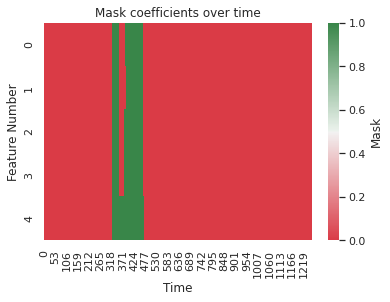

In [28]:
masks = mask.get_extremal_mask(threshold=0.3)
masks.plot_mask(smooth= False, sigma=2.0)

In [29]:
X_test[290:490]

,Adj Close,SMA,EMA,ROC,RSI
Date,,,,,
2019-02-28,79.287552,0.239529,0.422959,-0.609531,15.767492
2019-03-01,79.777344,0.161761,0.450941,-0.658536,17.876156
2019-03-04,79.674240,0.131259,0.423253,-0.262783,16.155031
2019-03-05,79.665657,0.134481,0.381198,-2.089060,16.002145
2019-03-06,79.373482,0.099248,0.290887,-2.862820,10.800540
...,...,...,...,...,...
2019-12-05,84.701454,0.048936,0.042641,-1.539907,0.947675
2019-12-06,85.486221,0.027994,0.174314,-1.809323,7.064132
2019-12-09,85.336319,0.023808,0.212858,-1.841554,5.199571
